In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yaml

In [2]:
# Load the parameter file. These are values that will remain fixed.
with open("../parameters/MegAWES.yaml", "r") as f:
    try:
        params = yaml.safe_load(f)
        kite = params['kite']
        tether = params['tether']
        environment = params['environment']

    except yaml.YAMLError as exc:
        print(exc)

In [10]:
ranges = {
    "vw_mps": np.linspace(0, 30, 100),  # windspeed [m/s]
    "beta_deg": [0.0, 30.0],            # elevation [deg]
    "phi_deg": [0.0, 17.5],             # azimuth [deg]
    "Lt_m": [500, 1000, 1500],       # tether length [m] (no mass effects, just drag).
}

# Make a new DataFrame that expands these ranges in all possible combinations.
df = pd.DataFrame(product(*ranges.values()), columns=ranges.keys())

In [11]:
def f_star(beta_deg, phi_deg):
    return 1/3 * np.cos(np.deg2rad(beta_deg)) * np.cos(np.deg2rad(phi_deg))

def E_eff(Lt_m):
    C_D = kite['C_L'] / kite['E']
    C_D_eff = C_D + 0.5 * tether['r_m'] * Lt_m / kite['S_m2'] * tether['Cd_t']
    return kite['C_L'] / C_D_eff

def Ftg_star(beta_deg, phi_deg, E_eff, vw_mps, f_star):
    q = 1/2 * environment['rho_kgpm3'] * vw_mps**2

    C_R = kite['C_L'] * np.sqrt(1 + 1/E_eff**2)
    return q * kite['S_m2'] * C_R * (1 + E_eff**2) * (np.cos(np.deg2rad(beta_deg)) * np.cos(np.deg2rad(phi_deg)) - f_star)**2

def P_star(vw_mps, f_star, Ft_star):
    return  vw_mps * f_star * Ft_star

In [12]:
df = df.assign(f_star = lambda row: f_star(row.beta_deg, row.phi_deg))
df = df.assign(E_eff = lambda row: E_eff(row.Lt_m))
df = df.assign(Ftg_N_star = lambda row: Ftg_star(row.beta_deg, row.phi_deg, row.E_eff, row.vw_mps, row.f_star))
df = df.assign(P_W_star = lambda row: P_star(row.vw_mps, row.f_star, row.Ftg_N_star))
df['vr_mps_star'] = df['f_star'] * df['vw_mps']

In [13]:
df

,vw_mps,beta_deg,phi_deg,Lt_m,f_star,E_eff,Ftg_N_star,P_W_star,vr_mps_star
0,0.0,0.0,0.0,500,0.333333,7.455599,0.000000e+00,0.000000e+00,0.000000
1,0.0,0.0,0.0,1000,0.333333,6.702092,0.000000e+00,0.000000e+00,0.000000
2,0.0,0.0,0.0,1500,0.333333,6.086913,0.000000e+00,0.000000e+00,0.000000
3,0.0,0.0,17.5,500,0.317906,7.455599,0.000000e+00,0.000000e+00,0.000000
4,0.0,0.0,17.5,1000,0.317906,6.702092,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...
1195,30.0,30.0,0.0,1000,0.288675,6.702092,2.310238e+06,2.000724e+07,8.660254
1196,30.0,30.0,0.0,1500,0.288675,6.086913,1.918826e+06,1.661752e+07,8.660254
1197,30.0,30.0,17.5,500,0.275314,7.455599,2.584113e+06,2.134330e+07,8.259431
1198,30.0,30.0,17.5,1000,0.275314,6.702092,2.101337e+06,1.735585e+07,8.259431


In [14]:
df.to_csv("../results/MegAWES_massless_analytical.csv")

# Plotting

In [15]:
px.line(df, x='vw_mps', y='P_W_star', color='beta_deg', symbol='phi_deg', facet_col='Lt_m')

AttributeError: Line2D.set() got an unexpected keyword argument 'col'

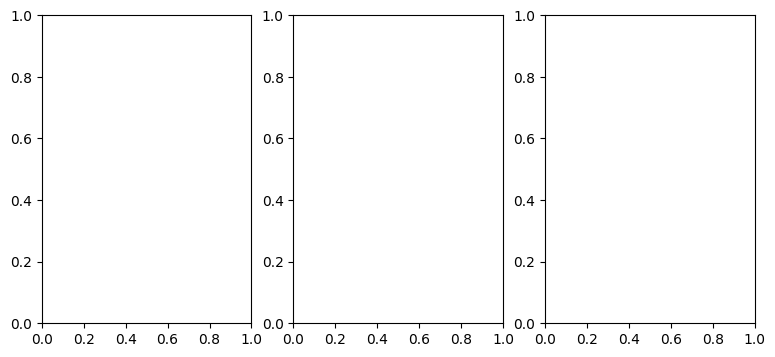

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15.75/2.54+3, 4))

ys = ['f_star', 'Ft_N_star', 'P_W_star']
for i, y in enumerate(ys):
    sns.lineplot(data=df, x='vw_mps', y=y, hue='beta_deg', style='phi_deg', col='Lt_m', ax=axs[i], legend=True if i == 2 else False)

# axs[2].legend(bbox_to_anchor=(1.05, 1.05))
for ax in axs:
    ax.set_xlabel('windspeed [m/s]')

axs[0].set_ylabel('f* [-]')
axs[1].set_ylabel('Ft* [N]')
axs[2].set_ylabel('P* [W]')
plt.tight_layout()



In [ ]:
df['vr_star_mps'] = df['f_star'] * df['vw_mps']

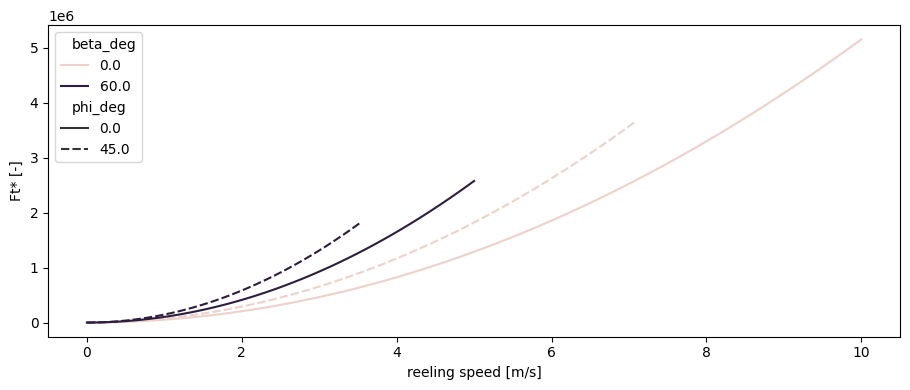

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15.75/2.54+3, 4))

sns.lineplot(data=df, x='vr_star_mps', y='Ft_N_star', hue='beta_deg', style='phi_deg', ax=ax)

ax.set_xlabel('reeling speed [m/s]')
ax.set_ylabel('Ft* [-]')
plt.tight_layout()